# Import necessary libraries


In [1]:
import numpy as np  # Numerical calculations
import pymc3 as pm  # Bayesian statistical modeling
import arviz as az  # Visualization for Bayesian analysis results
import pandas as pd  # Data processing
from scipy.stats import ttest_ind  # Statistical test
import matplotlib.pyplot as plt  # Plotting
import matplotlib as mpl  # Plotting settings
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.preprocessing import StandardScaler  # Data standardization
from sklearn.cluster import KMeans  # Clustering algorithm
from pymc3.gp.util import plot_gp_dist  # Import Gaussian process plotting tool from PyMC3

# Set default font and size for plotting
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.unicode_minus'] = False

# Update plotting parameters
plt.rcParams.update({
    'axes.spines.bottom': True,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False
})


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define the "true value" function

Text(0.5, 1.0, '图1：任务空间中的系数')

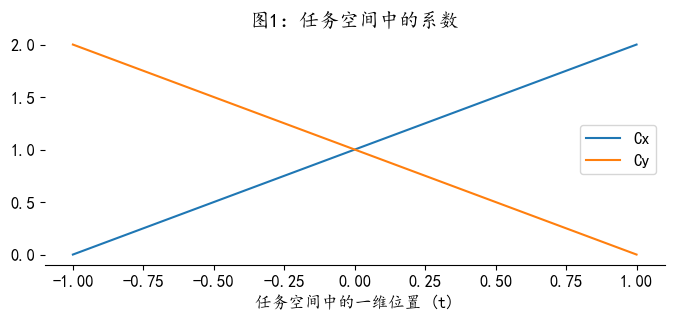

In [2]:
def measure_task(t):
    # Define the coefficients corresponding to task position t in the task space
    Cx = t + 1
    Cy = -t + 1
    b = 0
    return Cx, Cy, b

# Generate sample points in the task space
tt = np.linspace(-1, 1, 100)
Cx, Cy, b = measure_task(tt)

# Plot the coefficients as they change with task position in the task space
plt.figure(figsize=(8, 3))
plt.plot(tt, Cx, label="Cx")
plt.plot(tt, Cy, label="Cy")
plt.xlabel("One-dimensional position in the task space (t)")
plt.legend()
plt.title("Figure 1: Coefficients in the Task Space")
plt.show()


# Define the world model and measurement function

In [3]:
def ground_truth(x, y, t):
    # Compute the "true" output value z at the team space point (x, y) and task space point 't'
    Cx_t, Cy_t, b = measure_task(t)
    z = Cx_t * x + Cy_t * y + b
    return z

def measure(x, y, t):
    # Perform an experiment at the team space point (x, y) and task space point 't', and return the result with measurement noise
    sigma = .5  # Set the noise standard deviation
    z_measured = ground_truth(x, y, t) + np.random.normal(loc=0, scale=sigma, size=np.shape(x))
    return z_measured

# Measure the result at (x=1, y=1, t=1)
measure(x=1, y=1, t=1)


1.490624176340011

# Plot the true values in the team space

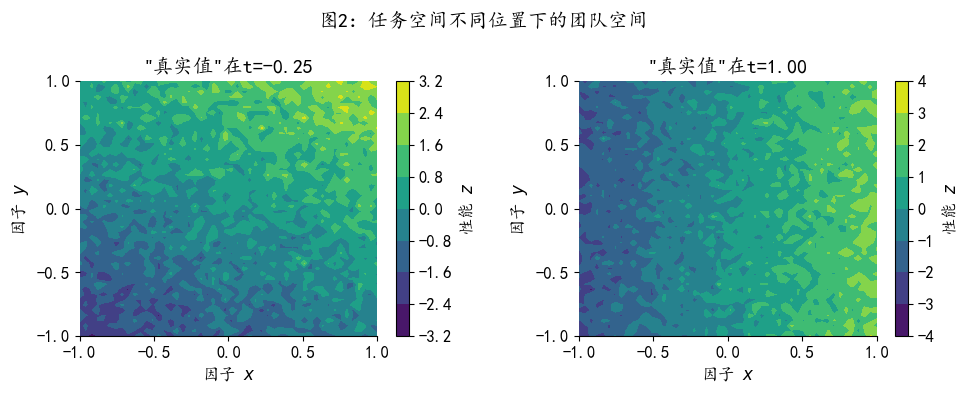

In [4]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))

plt.figure(figsize=(10, 4))

# Plot the true values in the team space at t=-0.25
plt.subplot(1, 2, 1)
t = -.25
zz_observations = measure(xx, yy, t)
plt.contourf(xx, yy, zz_observations)
plt.xlabel("Factor $x$")
plt.ylabel("Factor $y$")
plt.colorbar(label="Performance $z$")
plt.title('"True Value" at t=%.02f' % t)

# Plot the true values in the team space at t=1
plt.subplot(1, 2, 2)
t = 1
zz_observations = measure(xx, yy, t)
plt.contourf(xx, yy, zz_observations)
plt.xlabel("Factor $x$")
plt.ylabel("Factor $y$")
plt.colorbar(label="Performance $z$")
plt.title('"True Value" at t=%.02f' % t)

plt.suptitle("Figure 2: Team Space at Different Positions in the Task Space")
plt.tight_layout()
plt.show()


# Feature selection and preprocessing

In [5]:
def preprocess_features(features, n_components):
    # Dimensionality reduction using PCA
    pca = PCA(n_components=n_components)
    return pca.fit_transform(features)

# Redefine team space and task space
def redefine_space(features):
    # Standardize features
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Bucketing strategy
def bucketize_space(features, n_buckets):
    # Bucketize feature values
    buckets = np.linspace(features.min(), features.max(), n_buckets)
    bucketed_features = np.digitize(features, buckets)
    return bucketed_features


# Build MCMC model

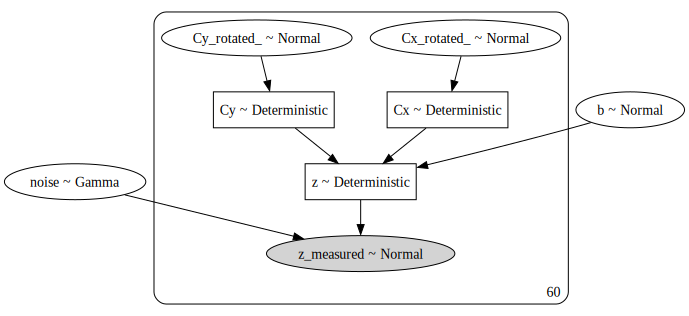

In [6]:
def build_model(x_sampled, y_sampled, t_sampled, z_observations, gp_length_scale=.4):
    n_samples = x_sampled.shape
    with pm.Model() as taskspace_hierarchical_model:
        cov_func = pm.gp.cov.ExpQuad(1, ls=gp_length_scale)
        gpx = pm.gp.Latent(cov_func=cov_func)
        gpy = pm.gp.Latent(cov_func=cov_func)

        Cx = gpx.prior("Cx", X=t_sampled[:, None], shape=n_samples)
        Cy = gpy.prior("Cy", X=t_sampled[:, None], shape=n_samples)

        # Normal prior for the intercept
        b = pm.Normal("b", mu=0, sd=10)
        # Gamma prior for noise
        noise = pm.Gamma("noise", alpha=2, beta=1)

        # Define linear function form in the team space
        z = pm.Deterministic("z", Cx * x_sampled + Cy * y_sampled + b)
        # Define Gaussian noise
        z_measured = pm.Normal("z_measured", mu=z, sd=noise, observed=z_observations)
        
    return taskspace_hierarchical_model, (gpx, gpy, b)

n_samples = 60
# Generate random samples
xs, ys, ts = np.random.uniform(-1, 1, size=(3, n_samples))
z_observations = measure(xs, ys, ts)

# Build model
taskspace_hierarchical_model, elements = build_model(xs, ys, ts, z_observations)
# Plot model structure
pm.model_to_graphviz(taskspace_hierarchical_model)


# MCMC sampling

In [7]:
with taskspace_hierarchical_model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, b, Cy_rotated_, Cx_rotated_]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 6000/6000 [08:12<00:00, 12.19draws/s]


# Define performance measurement function

C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.68it/s]


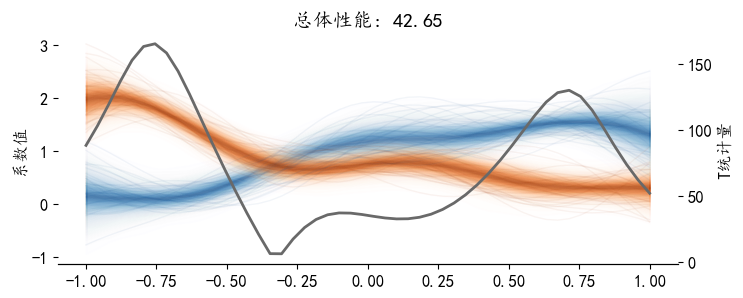

In [8]:
def draw_task_space(taskspace_hierarchical_model, elements, trace, ax, plot_t=np.linspace(-1, 1, 50)):
    gpx, gpy, b = elements
    
    with taskspace_hierarchical_model:
        # Define posterior predictive
        Cx_plot = gpx.conditional("Cx_plot", plot_t[:, None])
        Cy_plot = gpy.conditional("Cy_plot", plot_t[:, None])
        C_functions = pm.sample_posterior_predictive(trace, var_names=["Cx_plot", "Cy_plot"], samples=1000)
        
    # Plot the Gaussian process distribution for Cx
    plot_gp_dist(ax, C_functions["Cx_plot"], plot_t, palette="Blues", fill_alpha=.05, samples_alpha=.05)
    ax.plot([], [], 'cornflowerblue', alpha=1, linewidth=2, label="Cx")
    
    # Plot the Gaussian process distribution for Cy
    plot_gp_dist(ax, C_functions["Cy_plot"], plot_t, palette="Oranges", fill_alpha=.05, samples_alpha=.05)
    ax.plot([], [], 'darkorange', alpha=1, linewidth=2, label="Cy")
    ax.set_ylabel("Coefficient Value")
    
    # Calculate absolute t-statistics
    t_statistics = np.array([np.abs(ttest_ind(C_functions['Cx_plot'][:, i], C_functions['Cy_plot'][:, i]).statistic) for i in range(len(plot_t))])
    t_statistics = np.nan_to_num(t_statistics, nan=1.0, posinf=1.0, neginf=1.0)  # Handle nan and inf values
    ax2 = ax.twinx()
    ax2.plot(plot_t, t_statistics, 'dimgrey', linewidth=2)
    ax2.set_ylabel("T Statistic")
    ax.plot([], [], 'dimgrey', linewidth=2, label="T Statistic")
    
    # Calculate overall performance
    valid_t_stats = t_statistics[t_statistics > 0]  
    if len(valid_t_stats) > 0:
        performance = 1 / np.mean(1 / valid_t_stats)
    else:
        performance = float('nan')
    ax.setTitle("Overall Performance: %.02f" % performance)
    
    plt.xlabel("One-dimensional position in the task space")
    return C_functions

plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 1, 1)
C_functions = draw_task_space(taskspace_hierarchical_model, elements, trace, ax=ax)
plt.show()


# Define the function to select the point with the maximum variance

In [9]:
def select_max_variance(taskspace_hierarchical_model, trace, candidate_xs, candidate_ys, candidate_ts, elements):
    gpx, gpy, b = elements
    with taskspace_hierarchical_model:
        Cx_candidates = gpx.conditional("Cx_candidates", candidate_ts[:, None])
        Cy_candidates = gpy.conditional("Cy_candidates", candidate_ts[:, None])
        performance_pred = pm.Deterministic("performance_pred", Cx_candidates * candidate_xs + Cy_candidates * candidate_ys + b)
        predictions = pm.sample_posterior_predictive(trace, var_names=["performance_pred"], samples=1000)
        
    score = predictions['performance_pred'].var(axis=0)

    choice_index = np.argmax(score)
    
    return candidate_xs[choice_index], candidate_ys[choice_index], candidate_ts[choice_index]

n_candidates = 3
candidate_xs, candidate_ys, candidate_ts = np.random.uniform(-1, 1, size=(3, n_candidates))
print("Candidate points:")
print('\n'.join([str(a) for a in zip(candidate_xs, candidate_ys, candidate_ts)]))

selection = select_max_variance(taskspace_hierarchical_model, trace, candidate_xs, candidate_ys, candidate_ts, elements)
print("Selected point:")
selection


候选点:
(-0.06872506766578823, 0.5525292219261915, 0.13413282325651177)
(-0.43727381556899125, -0.22053791835731262, 0.9707407290948746)
(-0.12268253144980457, 0.3672088043503914, -0.057887806591603974)


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.77it/s]

选定点:


(-0.43727381556899125, -0.22053791835731262, 0.9707407290948746)

# Active learning in the task space

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [noise, b, Cy_rotated_, Cx_rotated_]
Sampling 2 chains, 15 divergences: 100%|██████████████████████████████████████| 2000/2000 [00:36<00:00, 54.40draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8157095237574192, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.64it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [noise, b, Cy_rotated_, Cx_rotated_]
Sampling 2 chains, 27 divergences: 100%|██████████████████████████████████████| 2000/2000 [00:41<00:00, 48.78draws/s]
There

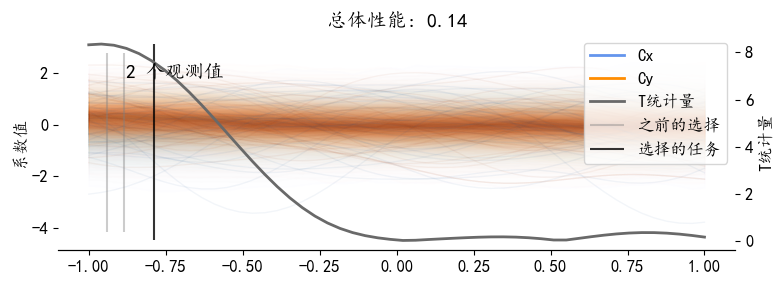

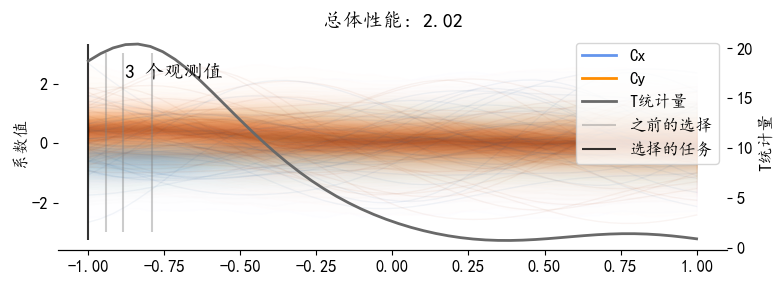

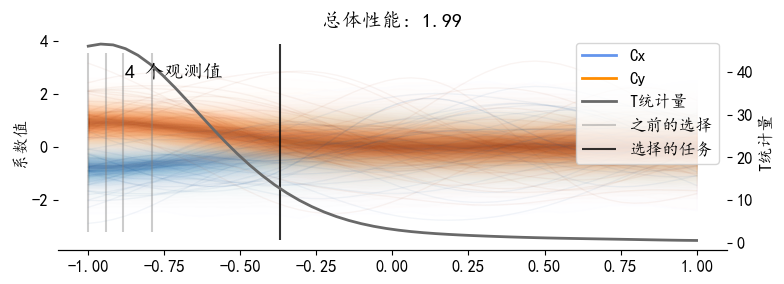

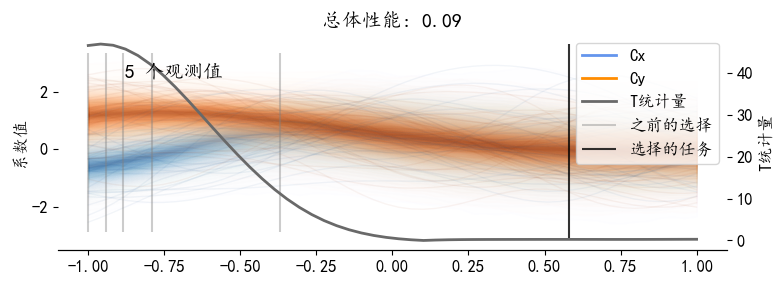

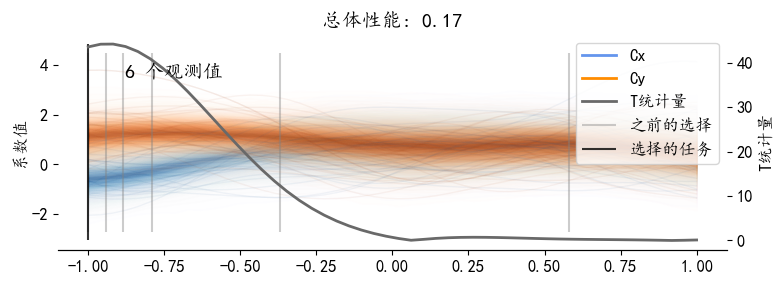

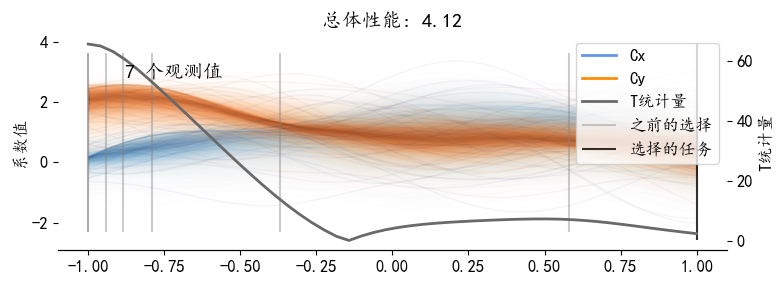

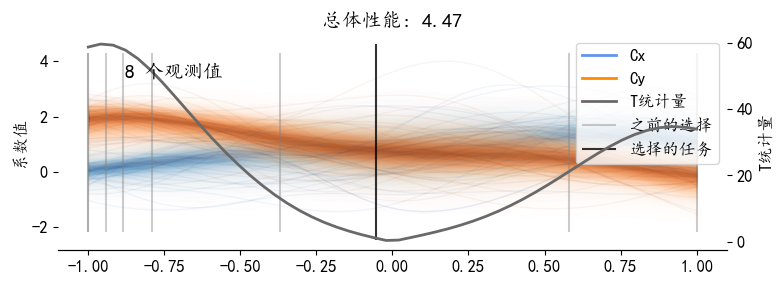

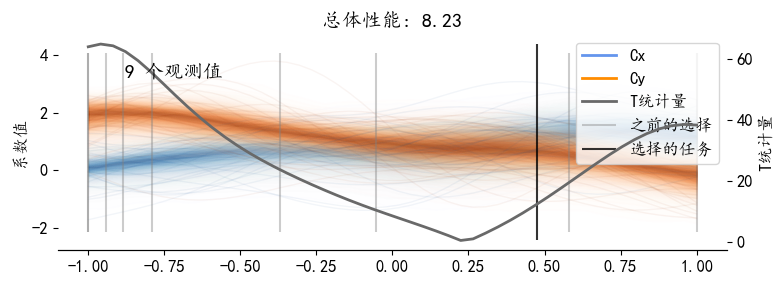

In [12]:
n_initial_samples = 2
xs, ys, ts = np.random.uniform(-1, 1, size=(3, n_initial_samples))
z_observations = measure(xs, ys, ts)

candidate_xs, candidate_ys, candidate_ts = np.meshgrid(
    np.linspace(-1, 1, 2),
    np.linspace(-1, 1, 2),
    np.linspace(-1, 1, 20),
)

n_iterations = 8
for i in range(n_iterations):
    taskspace_hierarchical_model, elements = build_model(xs, ys, ts, z_observations)
    with taskspace_hierarchical_model:
        trace = pm.sample(500, tune=500, target_accept=0.9, chains=2)

    selection = select_max_variance(
        taskspace_hierarchical_model, trace, 
        candidate_xs.flatten(), candidate_ys.flatten(), candidate_ts.flatten(), 
        elements
    )
    
    # Perform the next sample measurement
    next_observation = measure(*selection)
        
    # Plot the current state of knowledge and the next decision
    plt.figure(figsize=(8, 3))
    ax = plt.subplot(1, 1, 1)
    C_functions = draw_task_space(taskspace_hierarchical_model, elements, trace, ax=ax)
    ax.vlines(ts, *ax.get_ylim(), color='grey', label="Previous Choices", alpha=.4)
    ax.vlines(selection[2], *ax.get_ylim(), color='k', label='Selected Task', alpha=.8)
    plt.tight_layout()
    plt.annotate("%i Observations" % len(z_observations), xy=(.1, .8), xycoords='axes fraction', fontsize=14)
    ax.legend(loc="upper right")
    
    # Add new sample to the dataset
    xs = np.append(xs, selection[0])
    ys = np.append(ys, selection[1])
    ts = np.append(ts, selection[2])
    z_observations = np.append(z_observations, next_observation)


# Dynamic feature processing and clustering experiments

In [ ]:
def generate_random_data(n_samples, n_features):
    return np.random.uniform(-1, 1, size=(n_samples, n_features))

def measure(features, t):
    C = t[:, None] + np.arange(features.shape[1])
    b = 0
    z_measured = np.dot(features, C.T) + b + np.random.normal(loc=0, scale=0.5, size=features.shape[0])
    return z_measured

def build_model(features, t_sampled, z_observations, gp_length_scale=0.4):
    n_samples, n_features = features.shape
    with pm.Model() as model:
        cov_func = pm.gp.cov.ExpQuad(1, ls=gp_length_scale)
        gp = [pm.gp.Latent(cov_func=cov_func) for _ in range(n_features)]
        
        C = [gp[i].prior(f"C_{i}", X=t_sampled[:, None]) for i in range(n_features)]
        
        b = pm.Normal("b", mu=0, sd=10)
        noise = pm.Gamma("noise", alpha=2, beta=1)
        
        z = pm.Deterministic("z", sum(C[i] * features[:, i] for i in range(n_features)) + b)
        z_measured = pm.Normal("z_measured", mu=z, sd=noise, observed=z_observations)
        
    return model, gp

def draw_task_space(model, gp, trace, ax, plot_t=np.linspace(-1, 1, 50)):
    n_features = len(gp)
    
    with model:
        C_plot = [gp[i].conditional(f"C_plot_{i}", plot_t[:, None]) for i in range(n_features)]
        C_functions = pm.sample_posterior_predictive(trace, var_names=[f"C_plot_{i}" for i in range(n_features)], samples=1000)
    
    for i in range(n_features):
        plot_gp_dist(ax, C_functions[f"C_plot_{i}"], plot_t, palette="Blues", fill_alpha=.05, samples_alpha=.05)
        ax.plot([], [], 'cornflowerblue', alpha=1, linewidth=2, label=f"C_{i}")
    
    ax.set_ylabel("Coefficient Value")
    t_statistics = np.array([np.abs(ttest_ind(C_functions[f'C_plot_{i}'][:, j], C_functions[f'C_plot_{(i+1)%n_features}'][:, j]).statistic) for i in range(n_features) for j in range(len(plot_t))])
    
    ax2 = ax.twinx()
    ax2.plot(plot_t, t_statistics, 'dimgrey', linewidth=2)
    ax2.set_ylabel("T Statistic")
    ax.plot([], [], 'dimgrey', linewidth=2, label="T Statistic")
    
    performance = 1/np.mean(1/t_statistics)
    ax.set_title("Overall Performance: %.02f" % performance)
    
    plt.xlabel("One-dimensional position in the task space")
    return C_functions

def select_max_variance(model, trace, candidate_features, candidate_t, gp):
    n_features = len(gp)
    with model:
        C_candidates = [gp[i].conditional(f"C_candidates_{i}", candidate_t[:, None]) for i in range(n_features)]
        performance_pred = pm.Deterministic("performance_pred", sum(C_candidates[i] * candidate_features[:, i] for i in range(n_features)) + trace["b"])
        predictions = pm.sample_posterior_predictive(trace, var_names=["performance_pred"], samples=1000)
    
    score = predictions['performance_pred'].var(axis=0)
    choice_index = np.argmax(score)
    return candidate_features[choice_index], candidate_t[choice_index]

def main():
    n_samples = 30 
    n_features = 3
    features = generate_random_data(n_samples, n_features)
    t_sampled = np.random.uniform(-1, 1, size=n_samples)
    z_observations = measure(features, t_sampled)
    
    model, gp = build_model(features, t_sampled, z_observations)
    with model:
        trace = pm.sample(500, tune=2000, target_accept=0.9, chains=2)  
    
    fig, ax = plt.subplots(figsize=(8, 3))
    draw_task_space(model, gp, trace, ax=ax)
    plt.show()

    # Clustering experiments
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(features)
    
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)
        cluster_features = features[cluster_indices]
        cluster_t_sampled = t_sampled[cluster_indices]
        cluster_z_observations = z_observations[cluster_indices]
        
        model, gp = build_model(cluster_features, cluster_t_sampled, cluster_z_observations)
        with model:
            trace = pm.sample(500, tune=2000, target_accept=0.9, chains=2)  # Adjust sampling parameters
        
        fig, ax = plt.subplots(figsize=(8, 3))
        draw_task_space(model, gp, trace, ax=ax)
        plt.title(f"Cluster {cluster}")
        plt.show()

main()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [noise, b, C_2_rotated_, C_1_rotated_, C_0_rotated_]

Sampling 2 chains, 0 divergences:  10%|███▊                                  | 502/5000 [21:59<1:24:53,  1.13s/draws]